## Task 1B and part of Task1C
1. **Data Cleaning**: Validates data entries against expected ranges and handles missing or extreme values.
2. **Feature Engineering**: Extracts time-based features and interpolates missing values for continuous variables.
3. **Data Aggregation**: Computes daily averages and sums for specified metrics, and handles missing values with appropriate imputation strategies.
4. **Analysis of Continuous Intervals**: Identifies and isolates the longest continuous intervals with mood data available.
5. **Rolling Window Features and Dummy Variables**: Calculates rolling averages for mood-related variables and encodes weekdays into dummy variables.
6. **Preparation for Modeling**: Shifts mood averages to create a target variable for predictive modeling, resulting in a final dataset ready for analysis or machine learning applications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataset_mood_smartphone.csv')

# check the variable range
variable_ranges = {
    "mood": range(1, 11),
    "circumplex.arousal": range(-2, 3),
    "circumplex.valence": range(-2, 3),
    "activity": [0, 1],
    "call": {0, 1},
    "sms": {0, 1}
}

df['valid'] = df.apply(lambda x: x['variable'] not in variable_ranges or x['value'] in variable_ranges[x['variable']], axis=1)
df = df[df['valid']]
df.drop(columns=['valid'], inplace=True)

def handle_extreme_values(sub_df, column):
    Q1 = sub_df[column].quantile(0.25)
    Q3 = sub_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    sub_df[column] = sub_df[column].clip(lower, upper)
    return sub_df

for var in df['variable'].unique():
    for id in df['id'].unique():
        mask = (df['variable'] == var) & (df['id'] == id)
        df.loc[mask, :] = handle_extreme_values(df.loc[mask, :], 'value')

df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# df.loc[df['variable'] == 'circumplex.arousal', 'value'] = df.loc[df['variable'] == 'circumplex.arousal', 'value'].interpolate(method='linear')
# df.loc[df['variable'] == 'circumplex.valence', 'value'] = df.loc[df['variable'] == 'circumplex.valence', 'value'].interpolate(method='linear')
df.loc[df['variable'] == 'circumplex.arousal', 'value'] = df.loc[df['variable'] == 'circumplex.arousal', 'value'].interpolate(method='nearest')
df.loc[df['variable'] == 'circumplex.valence', 'value'] = df.loc[df['variable'] == 'circumplex.valence', 'value'].interpolate(method='nearest')

df = df.drop(df[(df['variable'].str.startswith('appCat')) & (df['value'] < 0)].index)

df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday

average_vars = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
sum_vars = [col for col in df['variable'].unique() if col not in average_vars]
num_vars = ['screen']

aggregated_data = pd.DataFrame()

for var in average_vars:
    avg_data = df[df['variable'] == var].groupby(['id', 'date'])['value'].mean().reset_index(name=f'{var}_avg')
    if aggregated_data.empty:
        aggregated_data = avg_data
    else:
        aggregated_data = pd.merge(aggregated_data, avg_data, on=['id', 'date'], how='outer')

for var in sum_vars:
    sum_data = df[df['variable'] == var].groupby(['id', 'date'])['value'].sum().reset_index(name=f'{var}_sum')
    aggregated_data = pd.merge(aggregated_data, sum_data, on=['id', 'date'], how='outer')
    
for var in num_vars:
    num_data = df[df['variable'] == var].groupby(['id', 'date'])['value'].count().reset_index(name=f'{var}_num')
    aggregated_data = pd.merge(aggregated_data, num_data, on=['id', 'date'], how='outer')
    
sum_columns = [col for col in aggregated_data.columns if 'sum' in col]
aggregated_data[sum_columns] = aggregated_data[sum_columns].fillna(0)
aggregated_data['activity_avg'] = aggregated_data['activity_avg'].fillna(0)

# use mean will perform worse
# sum_columns = [col for col in aggregated_data.columns if 'sum' in col]
# aggregated_data[sum_columns] = aggregated_data.groupby('id')[sum_columns].transform(lambda x: x.fillna(x.mean()))
# aggregated_data['activity_avg'] = aggregated_data.groupby('id')['activity_avg'].transform(lambda x: x.fillna(x.mean()))

aggregated_data['date'] = pd.to_datetime(aggregated_data['date'])
aggregated_data.sort_values(by=['id', 'date'], inplace=True)

def find_max_continuous_interval(group):
    group['has_data'] = ~group['mood_avg'].isnull()
    group['date_diff'] = group['date'].diff().fillna(pd.Timedelta(days=0)).dt.days - 1
    group['interval_id'] = 0
    current_interval = 0
    gap_days = 0

    for idx, row in group.iterrows():
        if row['has_data']:
            if gap_days > 3: 
                current_interval += 1
            group.at[idx, 'interval_id'] = current_interval
            gap_days = 0
        else:
            gap_days += row['date_diff']

    interval_sizes = group[group['has_data']].groupby('interval_id').size()

    max_interval_size = interval_sizes.max()
    max_interval_id = interval_sizes.idxmax()

    max_interval_dates = group[(group['interval_id'] == max_interval_id) & group['has_data']]['date']
    return group[group['date'].between(max_interval_dates.min(), max_interval_dates.max())]

max_intervals = aggregated_data.groupby('id').apply(find_max_continuous_interval).reset_index(drop=True)

columns_to_interpolate = ['mood_avg', 'circumplex.arousal_avg', 'circumplex.valence_avg']
for column in columns_to_interpolate:
    if column in max_intervals.columns:
        # max_intervals[column] = max_intervals.groupby('id')[column].transform(lambda x: x.interpolate(method='linear'))
        max_intervals[column] = max_intervals.groupby('id')[column].transform(lambda x: x.interpolate(method='nearest'))
max_intervals.fillna({'screen_num': 0}, inplace=True)

max_intervals['mood_avg_5d'] = max_intervals.groupby('id')['mood_avg'].transform(lambda x: x.rolling(window=5).mean())
max_intervals['arousal_avg_5d'] = max_intervals.groupby('id')['circumplex.arousal_avg'].transform(lambda x: x.rolling(window=5).mean())
max_intervals['valence_avg_5d'] = max_intervals.groupby('id')['circumplex.valence_avg'].transform(lambda x: x.rolling(window=5).mean())
max_intervals['weekday'] = max_intervals['date'].dt.weekday
weekday_dummies = pd.get_dummies(max_intervals['weekday'], prefix='weekday')
new_columns = {f'weekday_{i}': f'weekday{i+1}' for i in range(7)}
weekday_dummies.rename(columns=new_columns, inplace=True)
max_intervals = pd.concat([max_intervals, weekday_dummies], axis=1)
max_intervals['target_mood'] = max_intervals.groupby('id')['mood_avg'].shift(-1)
dataset = max_intervals.drop(columns=['has_data', 'date_diff', 'interval_id']).dropna()

/var/folders/3c/2djcdl7j2db456whl4vm4j3c0000gn/T/ipykernel_50579/1424890097.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[column] = sub_df[column].clip(lower, upper)
/var/folders/3c/2djcdl7j2db456whl4vm4j3c0000gn/T/ipykernel_50579/1424890097.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df[column] = sub_df[column].clip(lower, upper)
/var/folders/3c/2djcdl7j2db456whl4vm4j3c0000gn/T/ipykernel_50579/1424890097.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [2]:
# df.columns()

In [2]:
dataset.to_csv("mood_dataset.csv",index=False)

drop the unnecessary columns

In [3]:
dataset = dataset.drop(columns = ['weekday1', 'weekday2', 'weekday3', 'weekday4', 'weekday5', 'weekday6', 'weekday7'])

## Feature Engineering
drop some columns according to the correlation matrix

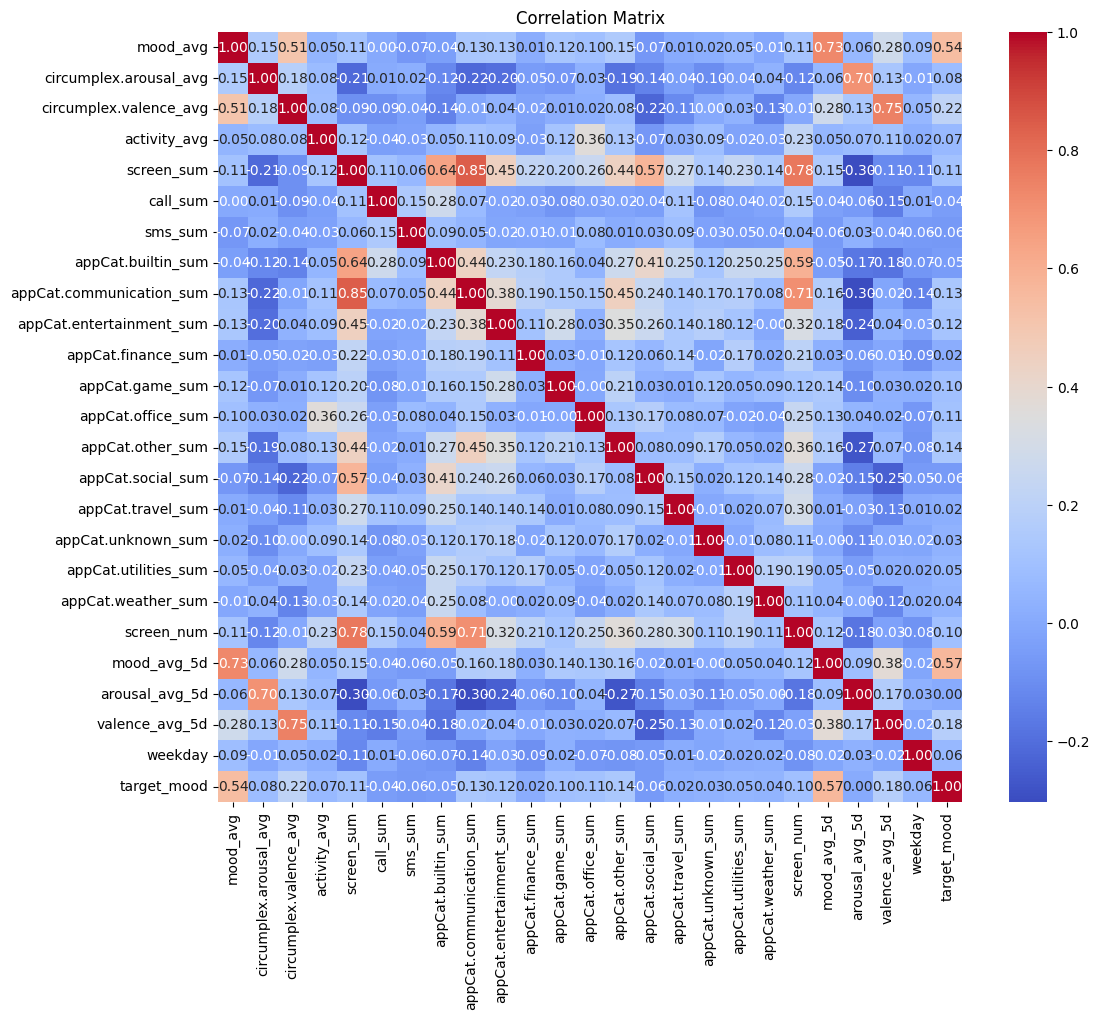

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
selected_columns = ['mood_avg', 'circumplex.arousal_avg', 'circumplex.valence_avg',
                    'activity_avg', 'screen_sum', 'call_sum', 'sms_sum', 
                    'appCat.builtin_sum', 'appCat.communication_sum', 
                    'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
                    'appCat.office_sum', 'appCat.other_sum', 'appCat.social_sum',
                    'appCat.travel_sum', 'appCat.unknown_sum', 'appCat.utilities_sum',
                    'appCat.weather_sum', 'screen_num', 'mood_avg_5d', 'arousal_avg_5d',
                    'valence_avg_5d', 'weekday', 'target_mood']

corr_subset = dataset[selected_columns]

correlation_matrix = corr_subset.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [5]:
min_corr_columns = correlation_matrix.sort_values(by='target_mood').head(10)

print("The columns with top 10 least relations:")
print(min_corr_columns)


The columns with top 10 least relations:
                      mood_avg  circumplex.arousal_avg  \
sms_sum              -0.068467                0.019844   
appCat.social_sum    -0.065919               -0.138860   
appCat.builtin_sum   -0.040479               -0.116569   
call_sum              0.002306                0.005235   
arousal_avg_5d        0.058976                0.698122   
appCat.finance_sum    0.014582               -0.051061   
appCat.travel_sum     0.006686               -0.038073   
appCat.unknown_sum    0.019402               -0.099870   
appCat.weather_sum   -0.011697                0.037851   
appCat.utilities_sum  0.053911               -0.035436   

                      circumplex.valence_avg  activity_avg  screen_sum  \
sms_sum                            -0.041386     -0.032470    0.060081   
appCat.social_sum                  -0.224739     -0.065304    0.574505   
appCat.builtin_sum                 -0.135783      0.048798    0.640877   
call_sum                

In [6]:
dataset_all = dataset.copy()
columns_to_drop = ['appCat.social_sum', 'appCat.builtin_sum', 
                   'appCat.entertainment_sum', 'appCat.weather_sum', 
                   'appCat.travel_sum']

dataset = dataset.drop(columns=columns_to_drop)

print(dataset.head())

        id       date  mood_avg  circumplex.arousal_avg  \
4  AS14.01 2014-03-25      6.75                     0.5   
5  AS14.01 2014-03-26      6.60                    -0.2   
6  AS14.01 2014-03-27      7.00                     0.2   
7  AS14.01 2014-03-28      6.50                    -0.6   
8  AS14.01 2014-03-29      8.00                     0.2   

   circumplex.valence_avg  activity_avg   screen_sum  call_sum  sms_sum  \
4                     0.5           0.0  8013.887127       0.0      1.0   
5                     0.6           0.0  8345.307628       0.0      0.0   
6                     0.8           0.0  7021.993502       2.0      1.0   
7                     0.6           0.0  3708.979126       5.0      0.0   
8                     1.0           0.0  3796.486377       4.0      1.0   

   appCat.communication_sum  ...  appCat.office_sum  appCat.other_sum  \
4                  6600.763  ...            0.00000          76.36950   
5                  6637.607  ...            0.00

In [7]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

features = dataset.drop(columns=['id', 'date'])

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(features)
selected_indices = selector.get_support(indices=True)
selected_columns = features.columns[selected_indices]
dataset_selected = pd.DataFrame(selected_features, columns=selected_columns)




In [8]:
dataset_selected

,mood_avg,circumplex.arousal_avg,circumplex.valence_avg,screen_sum,call_sum,sms_sum,appCat.communication_sum,appCat.finance_sum,appCat.game_sum,appCat.office_sum,appCat.other_sum,appCat.unknown_sum,appCat.utilities_sum,screen_num,mood_avg_5d,arousal_avg_5d,weekday,target_mood
0,6.75,0.500000,0.5,8013.887127,0.0,1.0,6600.7630,43.054,0.000,0.00000,76.36950,162.536875,222.893000,127.0,6.470000,0.420000,1.0,6.6
1,6.60,-0.200000,0.6,8345.307628,0.0,0.0,6637.6070,52.331,0.000,0.00000,78.86975,0.000000,33.365000,174.0,6.550000,0.340000,2.0,7.0
2,7.00,0.200000,0.8,7021.993502,2.0,1.0,5251.7670,42.219,0.000,178.16925,58.53200,0.000000,179.029000,135.0,6.650000,0.260000,3.0,6.5
3,6.50,-0.600000,0.6,3708.979126,5.0,0.0,866.8330,89.166,233.036,0.00000,112.54800,0.000000,244.758250,88.0,6.590000,0.100000,4.0,8.0
4,8.00,0.200000,1.0,3796.486377,4.0,1.0,2092.8750,0.000,0.000,0.00000,100.17850,0.000000,505.860125,64.0,6.970000,0.020000,5.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,5.70,-0.400000,0.0,6179.831997,10.0,3.0,1011.7780,0.000,0.000,130.53000,162.58550,0.000000,0.000000,63.0,6.048333,-0.446667,0.0,6.2
1156,6.20,-0.600000,0.4,3361.135500,1.0,2.0,1542.0475,0.000,0.000,0.00000,106.09250,0.000000,33.613500,36.0,6.113333,-0.666667,1.0,7.7
1157,7.70,0.000000,1.2,7512.987497,10.0,1.0,1826.9150,0.000,0.000,305.85900,292.60525,0.000000,30.666000,126.0,6.470000,-0.500000,2.0,7.0
1158,7.00,-1.333333,1.0,1127.340000,5.0,1.0,328.7155,0.000,0.000,0.00000,29.20200,0.000000,3.199000,30.0,6.570000,-0.616667,3.0,6.8


## Task2A APPLICATION OF CLASSIFICATION ALGORITHMS

### Random Forest

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# features = dataset.drop(columns=['id', 'date', 'target_mood'])
# target = dataset['target_mood'].round().astype(int)
features = dataset_selected.drop(columns=['target_mood'])
target = dataset_selected['target_mood'].round().astype(int)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

rf_classifier = RandomForestClassifier(random_state=42)

# GridSearchCV for hyper parameter optimizer
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("The best hyper parameter:", best_params)

best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

y_pred_rf = best_rf_classifier.predict(X_test)

print("Performance of random forest:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

/Users/amradwan/Desktop/vu/24-25/periode5/DM/Data_Mining1/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


The best hyper parameter: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Performance of random forest:
              precision    recall  f1-score   support

           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         6
           6       0.49      0.46      0.48        67
           7       0.66      0.77      0.71       198
           8       0.51      0.40      0.45        70
           9       1.00      0.00      0.00         4

    accuracy                           0.61       348
   macro avg       0.78      0.27      0.27       348
weighted avg       0.61      0.61      0.59       348



### LSTM

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import optuna

dataset['target_mood'] = dataset['target_mood'].round()

# max_intervals['target_mood'].fillna(max_intervals['target_mood'].mode()[0], inplace=True)

dataset.dropna(subset=['target_mood'], inplace=True)

dataset['target_mood'] = dataset['target_mood'].astype(int)

features = dataset_selected.drop(columns=['target_mood'])
targets = dataset_selected['target_mood'].round().astype(int).values - 1

num_classes = len(np.unique(targets))

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Use the last timestep of the sequence
        return x

def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 50, 100)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    model = LSTMClassifier(input_dim=features.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, output_dim=10)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))  # Add an extra dimension to match LSTM input
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_torch.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_torch).type(torch.float32).mean().item()

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params

print(f"Best parameters: {best_params}")

model = LSTMClassifier(input_dim=features.shape[1], hidden_dim=best_params['hidden_dim'], num_layers=best_params['num_layers'], output_dim=10)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/30, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_torch.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    y_true = y_test_torch.detach().cpu().tolist()
    y_pred = predicted.detach().cpu().tolist()
    print(classification_report(y_true, y_pred, zero_division=0))
    # print(classification_report(y_test_torch, predicted))



[I 2025-04-12 14:19:44,974] A new study created in memory with name: no-name-a5881bc3-396c-4017-bfd3-69e1def813ba
[I 2025-04-12 14:19:45,913] Trial 0 finished with value: 0.6293103694915771 and parameters: {'hidden_dim': 74, 'num_layers': 2, 'lr': 0.0005833104832202345}. Best is trial 0 with value: 0.6293103694915771.
[I 2025-04-12 14:19:46,433] Trial 1 finished with value: 0.642241358757019 and parameters: {'hidden_dim': 90, 'num_layers': 1, 'lr': 0.000942259624610649}. Best is trial 1 with value: 0.642241358757019.
[I 2025-04-12 14:19:46,980] Trial 2 finished with value: 0.27586206793785095 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'lr': 0.00010030609587707794}. Best is trial 1 with value: 0.642241358757019.
[I 2025-04-12 14:19:48,243] Trial 3 finished with value: 0.5905172228813171 and parameters: {'hidden_dim': 89, 'num_layers': 3, 'lr': 3.699644147955814e-05}. Best is trial 1 with value: 0.642241358757019.
[I 2025-04-12 14:19:48,726] Trial 4 finished with value: 0.14224

Best parameters: {'hidden_dim': 79, 'num_layers': 1, 'lr': 0.0014023818822178529}
Epoch 1/30, Loss: 2.205488443374634
Epoch 2/30, Loss: 2.0619800090789795
Epoch 3/30, Loss: 1.8165479898452759
Epoch 4/30, Loss: 1.5160281658172607
Epoch 5/30, Loss: 1.4959135055541992
Epoch 6/30, Loss: 1.1991698741912842
Epoch 7/30, Loss: 0.8474357724189758
Epoch 8/30, Loss: 0.9298203587532043
Epoch 9/30, Loss: 1.0154662132263184
Epoch 10/30, Loss: 0.7670642137527466
Epoch 11/30, Loss: 1.1090033054351807
Epoch 12/30, Loss: 0.8191490173339844
Epoch 13/30, Loss: 0.7635668516159058
Epoch 14/30, Loss: 0.9453414082527161
Epoch 15/30, Loss: 0.7341679930686951
Epoch 16/30, Loss: 0.6969447731971741
Epoch 17/30, Loss: 0.7072381973266602
Epoch 18/30, Loss: 0.7520937919616699
Epoch 19/30, Loss: 0.6943690776824951
Epoch 20/30, Loss: 0.872488796710968
Epoch 21/30, Loss: 0.8138202428817749
Epoch 22/30, Loss: 0.6953064203262329
Epoch 23/30, Loss: 0.6722995042800903
Epoch 24/30, Loss: 0.7393750548362732
Epoch 25/30, Loss

### Transformer

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import optuna  


dataset['target_mood'] = dataset['target_mood'].round()
dataset.dropna(subset=['target_mood'], inplace=True)
dataset['target_mood'] = dataset['target_mood'].astype(int)

features = dataset_selected.drop(columns=['target_mood'])
targets = dataset_selected['target_mood'].round().astype(int).values - 1

num_classes = int(max(targets)) + 1

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets, test_size=0.2, random_state=42
)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch  = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim):
        """
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Dimension for embedding and Transformer encoder.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of Transformer encoder layers.
            output_dim (int): Number of target classes.
        """
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: [batch, seq_len, input_dim]
        x = self.embedding(x)  # Now shape: [batch, seq_len, hidden_dim]
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

input_dim = features.shape[1]
hidden_dim = 64     
num_heads  = 4       
num_layers = 2       
output_dim = num_classes

model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_layers, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        # Add a sequence dimension: [batch, 1, feature_dim]
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_torch.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    print("\nClassification Report (Transformer):")
    y_true = y_test_torch.detach().cpu().tolist()
    y_pred = predicted.detach().cpu().tolist()
    print(classification_report(y_true, y_pred, zero_division=0))
    # print(classification_report(y_test_torch, predicted))
    


Epoch 1/60, Loss: 1.1520
Epoch 2/60, Loss: 0.9197
Epoch 3/60, Loss: 0.8932
Epoch 4/60, Loss: 0.8728
Epoch 5/60, Loss: 0.8519
Epoch 6/60, Loss: 0.8648
Epoch 7/60, Loss: 0.8233
Epoch 8/60, Loss: 0.8061
Epoch 9/60, Loss: 0.7858
Epoch 10/60, Loss: 0.7737
Epoch 11/60, Loss: 0.7644
Epoch 12/60, Loss: 0.7480
Epoch 13/60, Loss: 0.7118
Epoch 14/60, Loss: 0.6838
Epoch 15/60, Loss: 0.6996
Epoch 16/60, Loss: 0.6740
Epoch 17/60, Loss: 0.6451
Epoch 18/60, Loss: 0.6345
Epoch 19/60, Loss: 0.6421
Epoch 20/60, Loss: 0.5706
Epoch 21/60, Loss: 0.5570
Epoch 22/60, Loss: 0.5347
Epoch 23/60, Loss: 0.5255
Epoch 24/60, Loss: 0.5371
Epoch 25/60, Loss: 0.4757
Epoch 26/60, Loss: 0.4687
Epoch 27/60, Loss: 0.4825
Epoch 28/60, Loss: 0.4468
Epoch 29/60, Loss: 0.4364
Epoch 30/60, Loss: 0.3861
Epoch 31/60, Loss: 0.3702
Epoch 32/60, Loss: 0.4198
Epoch 33/60, Loss: 0.3806
Epoch 34/60, Loss: 0.3764
Epoch 35/60, Loss: 0.3242
Epoch 36/60, Loss: 0.3550
Epoch 37/60, Loss: 0.3280
Epoch 38/60, Loss: 0.2986
Epoch 39/60, Loss: 0.

## GRU with attention

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import optuna 


dataset['target_mood'] = dataset['target_mood'].round()
dataset.dropna(subset=['target_mood'], inplace=True)
dataset['target_mood'] = dataset['target_mood'].astype(int)

features = dataset_selected.drop(columns=['target_mood'])
targets = dataset_selected['target_mood'].round().astype(int).values - 1

num_classes = int(max(targets)) + 1

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, targets, test_size=0.2, random_state=42
)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch  = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


class GRUAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        """
        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Hidden state dimension for the GRU.
            num_layers (int): Number of GRU layers.
            output_dim (int): Number of target classes.
        """
        super(GRUAttentionClassifier, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: [batch, seq_len, input_dim]
        gru_out, _ = self.gru(x)  # gru_out: [batch, seq_len, hidden_dim]
        attn_scores = self.attn(gru_out)  # Shape: [batch, seq_len, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # Shape: [batch, seq_len, 1]
        # Compute context vector as a weighted sum of GRU outputs.
        context = torch.sum(attn_weights * gru_out, dim=1)  # Shape: [batch, hidden_dim]
        output = self.fc(context)
        return output

input_dim = features.shape[1]
hidden_dim = 64  # Adjust as desired.
num_layers = 2   # Adjust number of layers as needed.
output_dim = num_classes

model = GRUAttentionClassifier(input_dim, hidden_dim, num_layers, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        # Add a singleton sequence dimension: [batch, 1, feature_dim]
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_torch.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    print("\nClassification Report (GRU with Attention):")
    y_true = y_test_torch.detach().cpu().tolist()
    y_pred = predicted.detach().cpu().tolist()
    print(classification_report(y_true, y_pred, zero_division=0))
    # print(classification_report(y_test_torch, predicted))



Epoch 1/30, Loss: 2.0834
Epoch 2/30, Loss: 1.9259
Epoch 3/30, Loss: 1.6638
Epoch 4/30, Loss: 1.3219
Epoch 5/30, Loss: 1.0562
Epoch 6/30, Loss: 0.9568
Epoch 7/30, Loss: 0.9137
Epoch 8/30, Loss: 0.8884
Epoch 9/30, Loss: 0.8791
Epoch 10/30, Loss: 0.8602
Epoch 11/30, Loss: 0.8593
Epoch 12/30, Loss: 0.8491
Epoch 13/30, Loss: 0.8439
Epoch 14/30, Loss: 0.8327
Epoch 15/30, Loss: 0.8423
Epoch 16/30, Loss: 0.8413
Epoch 17/30, Loss: 0.8251
Epoch 18/30, Loss: 0.8189
Epoch 19/30, Loss: 0.8180
Epoch 20/30, Loss: 0.8265
Epoch 21/30, Loss: 0.8211
Epoch 22/30, Loss: 0.8174
Epoch 23/30, Loss: 0.8054
Epoch 24/30, Loss: 0.8143
Epoch 25/30, Loss: 0.8108
Epoch 26/30, Loss: 0.7985
Epoch 27/30, Loss: 0.7997
Epoch 28/30, Loss: 0.7905
Epoch 29/30, Loss: 0.7886
Epoch 30/30, Loss: 0.7901

Classification Report (GRU with Attention):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         6
           5       0.

In [22]:
from mlxtend.frequent_patterns import apriori, fpgrowth, fpmax
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

transactions = dataset_all[['mood_avg', 'circumplex.arousal_avg', 'circumplex.valence_avg', 'activity_avg', 'screen_sum', 'call_sum',
                   'sms_sum', 'appCat.builtin_sum', 'appCat.communication_sum', 'appCat.entertainment_sum', 'appCat.finance_sum',
                   'appCat.game_sum', 'appCat.office_sum', 'appCat.other_sum', 'appCat.social_sum', 'appCat.travel_sum',
                   'appCat.unknown_sum', 'appCat.utilities_sum', 'appCat.weather_sum', 'screen_num', 'mood_avg_5d',
                   'arousal_avg_5d', 'valence_avg_5d', 'weekday', 'target_mood']].values.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm
frequent_itemsets_apriori = apriori(df_encoded, min_support=0.1, use_colnames=True)

# Apply FP-Growth algorithm
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.1, use_colnames=True)

# Apply ECLAT algorithm
frequent_itemsets_fpmax = fpmax(df_encoded, min_support=0.1, use_colnames=True)

# Print the frequent itemsets
print("Frequent Itemsets (Apriori):\n", frequent_itemsets_apriori)


Frequent Itemsets (Apriori):
      support         itemsets
0   1.000000            (0.0)
1   0.106897            (0.2)
2   0.116379            (0.4)
3   0.765517            (1.0)
4   0.297414            (2.0)
5   0.229310            (3.0)
6   0.224138            (4.0)
7   0.186207            (5.0)
8   0.231897            (6.0)
9   0.382759            (7.0)
10  0.127586            (7.2)
11  0.117241            (8.0)
12  0.106897       (0.0, 0.2)
13  0.116379       (0.0, 0.4)
14  0.765517       (0.0, 1.0)
15  0.297414       (0.0, 2.0)
16  0.229310       (0.0, 3.0)
17  0.224138       (0.0, 4.0)
18  0.186207       (0.0, 5.0)
19  0.231897       (0.0, 6.0)
20  0.382759       (0.0, 7.0)
21  0.127586       (0.0, 7.2)
22  0.117241       (0.0, 8.0)
23  0.215517       (1.0, 2.0)
24  0.160345       (1.0, 3.0)
25  0.163793       (1.0, 4.0)
26  0.142241       (1.0, 5.0)
27  0.162931       (1.0, 6.0)
28  0.317241       (1.0, 7.0)
29  0.100862       (1.0, 7.2)
30  0.109483       (2.0, 7.0)
31  0.2155

In [23]:

print("Frequent Itemsets (FP-Growth):\n", frequent_itemsets_fpgrowth)

Frequent Itemsets (FP-Growth):
      support         itemsets
0   1.000000            (0.0)
1   0.765517            (1.0)
2   0.116379            (0.4)
3   0.382759            (7.0)
4   0.297414            (2.0)
5   0.229310            (3.0)
6   0.106897            (0.2)
7   0.224138            (4.0)
8   0.186207            (5.0)
9   0.117241            (8.0)
10  0.231897            (6.0)
11  0.127586            (7.2)
12  0.765517       (0.0, 1.0)
13  0.116379       (0.0, 0.4)
14  0.382759       (0.0, 7.0)
15  0.317241       (1.0, 7.0)
16  0.317241  (0.0, 1.0, 7.0)
17  0.297414       (0.0, 2.0)
18  0.109483       (2.0, 7.0)
19  0.215517       (1.0, 2.0)
20  0.109483  (0.0, 2.0, 7.0)
21  0.215517  (0.0, 1.0, 2.0)
22  0.229310       (0.0, 3.0)
23  0.160345       (1.0, 3.0)
24  0.160345  (0.0, 1.0, 3.0)
25  0.106897       (0.0, 0.2)
26  0.224138       (0.0, 4.0)
27  0.163793       (1.0, 4.0)
28  0.163793  (0.0, 1.0, 4.0)
29  0.186207       (0.0, 5.0)
30  0.142241       (1.0, 5.0)
31  0.14

In [25]:
print("Frequent Itemsets (FP-max):\n", frequent_itemsets_fpmax)

Frequent Itemsets (FP-max):
      support         itemsets
0   0.106897       (0.0, 0.2)
1   0.116379       (0.0, 0.4)
2   0.117241       (0.0, 8.0)
3   0.100862  (0.0, 1.0, 7.2)
4   0.142241  (0.0, 1.0, 5.0)
5   0.163793  (0.0, 1.0, 4.0)
6   0.160345  (0.0, 1.0, 3.0)
7   0.162931  (0.0, 1.0, 6.0)
8   0.109483  (0.0, 2.0, 7.0)
9   0.215517  (0.0, 1.0, 2.0)
10  0.317241  (0.0, 1.0, 7.0)


In [24]:
apriori_sorted = frequent_itemsets_apriori.sort_values(by='support')
fpgrowth_sorted = frequent_itemsets_fpgrowth.sort_values(by='support')
fpmax_sorted = frequent_itemsets_fpmax.sort_values(by='support')

print("Frequent Itemsets (Apriori - Bottom 5):")
print(apriori_sorted.head(5))

print("\nFrequent Itemsets (FP-Growth - Bottom 5):")
print(fpgrowth_sorted.head(5))

print("\nFrequent Itemsets (FP- Max - Bottom 5):")
print(fpmax_sorted.head(5))


Frequent Itemsets (Apriori - Bottom 5):
     support         itemsets
29  0.100862       (1.0, 7.2)
37  0.100862  (0.0, 1.0, 7.2)
12  0.106897       (0.0, 0.2)
1   0.106897            (0.2)
38  0.109483  (0.0, 2.0, 7.0)

Frequent Itemsets (FP-Growth - Bottom 5):
     support         itemsets
37  0.100862       (1.0, 7.2)
38  0.100862  (0.0, 1.0, 7.2)
6   0.106897            (0.2)
25  0.106897       (0.0, 0.2)
18  0.109483       (2.0, 7.0)

Frequent Itemsets (FP- Max - Bottom 5):
    support         itemsets
3  0.100862  (0.0, 1.0, 7.2)
0  0.106897       (0.0, 0.2)
8  0.109483  (0.0, 2.0, 7.0)
1  0.116379       (0.0, 0.4)
2  0.117241       (0.0, 8.0)
